In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicle-detection-image-set/data/vehicles/right (28).png
/kaggle/input/vehicle-detection-image-set/data/vehicles/4353.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/5511.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/2664.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/2539.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/5703.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/1231.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/1017.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/4803.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/left (153).png
/kaggle/input/vehicle-detection-image-set/data/vehicles/middle (34).png
/kaggle/input/vehicle-detection-image-set/data/vehicles/left (564).png
/kaggle/input/vehicle-detection-image-set/data/vehicles/2437.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/3217.png
/kaggle/input/vehicle-detection-image-set/data/vehicles/5695.png


# Import Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader
from torchvision import transforms as tt
from sklearn.utils import shuffle
import torchinfo
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

try:
    import torchmetrics
except:
    !pip install torchmetrics
    
from torchmetrics import Accuracy

height, width = 224, 224

### Let's check if GPU is available too.

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
device

device(type='cuda')

# Data Engineering

### A lot of the work when it comes to Deep Learning revolves around engineering the data and making it to exactly the format that is useful to us.

In [4]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = tt.Compose([
    tt.Resize((height, width)),
    tt.TrivialAugmentWide(num_magnitude_bins=31),
    tt.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = tt.Compose([
    tt.Resize((height, width)),
    tt.ToTensor()
])

### Now we have to split up the files to have train and test datasets.

In [5]:
from glob import glob
non_vehicles = glob('/kaggle/input/vehicle-detection-image-set/data/non-vehicles/*')
non_vehicles = non_vehicles[:8960]

vehicles = glob('/kaggle/input/vehicle-detection-image-set/data/vehicles/*')
vehicles = vehicles[:8768]

non_vehicles_train = non_vehicles[:6272]
non_vehicles_test = non_vehicles[6272:]

vehicles_train = vehicles[:6000]
vehicles_test = vehicles[6000:]

### Time to make our custom dataset.

In [6]:
class VehicleDetection(Dataset):
    def __init__(self, transform, non_vehicles, vehicles):
        self.non_vehicles = non_vehicles
        self.vehicles = vehicles
        self.transform = transform
        
        labels = [[1,0] for i in range(len(non_vehicles))]
        labels += [[0,1] for i in range(len(vehicles))]
        
        image_links = self.non_vehicles + self.vehicles
        
        self.df = pd.DataFrame({
            'image': image_links,
            'labels': labels
        })
        
        
    def __len__(self):
        return len(self.non_vehicles) + len(self.vehicles)
    
    def __getitem__(self, idx):
        
        image_list = self.df['image'][idx]
        label_list = self.df['labels'][idx]
        
        if type(image_list) == str:
            image_list = [image_list]

        if not isinstance(label_list,np.int64):
            label_list = torch.tensor(label_list, dtype=torch.float)
            
        for image in image_list:
            img = Image.open(image)
            
        return self.transform(img), label_list

In [7]:
train_data_custom = VehicleDetection(train_transform_trivial_augment, non_vehicles_train, vehicles_train)
test_data_custom = VehicleDetection(test_transform, non_vehicles_test, vehicles_test)

In [8]:
print(f"We have {len(train_data_custom)} training datapoints and {len(test_data_custom)} testing datapoints")

We have 12272 training datapoints and 5456 testing datapoints


### Let's make our **custom dataloaders** now.

In [9]:
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=32, # how many samples per batch?
                                     num_workers=2, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=32, 
                                    num_workers=2, 
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f41d3a4d0d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f41da292f50>)

### Let's check whether it is working correctly.

In [10]:
img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32, 2])


### Let's check whether any of our images have a different number of color channels. 
### There could be some erreneous images along the way with only a single color channel.

In [11]:
"""count = 0

for batch, (X,y) in enumerate(train_dataloader_custom):
    if (X.shape[1] != 3):
        count += 1
        
for batch, (X,y) in enumerate(test_dataloader_custom):
    if (X.shape[1] != 3):
        count += 1
        
print(count)
print(f"\nThere are {count/(len(train_dataloader_custom) + len(test_dataloader_custom))*100:.1f}% of errenous pictures")"""

'count = 0\n\nfor batch, (X,y) in enumerate(train_dataloader_custom):\n    if (X.shape[1] != 3):\n        count += 1\n        \nfor batch, (X,y) in enumerate(test_dataloader_custom):\n    if (X.shape[1] != 3):\n        count += 1\n        \nprint(count)\nprint(f"\nThere are {count/(len(train_dataloader_custom) + len(test_dataloader_custom))*100:.1f}% of errenous pictures")'

### Luckily for us, there seems to be no errors in the data. 
### Let's proceed on with importing our model to use.

# Basic CNN

### Let's first take a look at the performance of a basic CNN model.

In [12]:
class Basic_CNN(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_shape, 3, 1, 1), # hidden * 224 * 224
            nn.ReLU(),
            nn.Conv2d(hidden_shape, hidden_shape, 3, 1, 1), # hidden * 224 * 224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, # hidden * 112 * 112 
                         stride=2)
        )
        
        self.conv_2 = nn.Sequential(
            nn.Conv2d(hidden_shape, hidden_shape, 3, 1, 1), # hidden * 112 * 112 
            nn.ReLU(),
            nn.Conv2d(hidden_shape, hidden_shape, 3, 1, 1), # hidden * 112 * 112 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, # hidden * 56 * 56 
                         stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_shape * 56 * 56, output_shape)
        )
        
    def forward(self, x):
        return self.classifier(self.conv_2(self.conv_1(x)))
    
torch.manual_seed(42)
basic_model = Basic_CNN(3,32,2)
basic_model.to(device)

Basic_CNN(
  (conv_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=2, bias=True)
  )
)

In [13]:
# Setup loss function and optimizer
model = basic_model
lf = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

epochs = 100
acc_fn = Accuracy(task='binary').to(device)
train_loss_arr = []
test_loss_arr = []
test_acc_arr = []

for epoch in range(epochs):
    train_loss = 0
    
    for batch, (X,y) in enumerate(train_dataloader_custom):
            
        X = X.to(device)
        y = y.to(device)
        model.train()
        
        # Forward
        y_pred = model(X)
        
        # Calculate loss
        loss = lf(y_pred, y)
        train_loss += loss
        
        # Zero grad
        optimizer.zero_grad()
        
        # Loss backward
        loss.backward()
        
        # Optimizer step
        optimizer.step()
    
    train_loss/=len(train_dataloader_custom)
    train_loss_arr.append(train_loss.cpu().detach().numpy())
    
    test_loss, test_acc= 0, 0
    model.eval() 
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_dataloader_custom):
            
            X = X.to(device)
            y = y.to(device)
            
            # Forward
            test_pred = model(X)
            
            # Calculate loss 
            test_loss += lf(test_pred, y)
            
            # Calculate accuracy 
            acc_fn.update(test_pred.argmax(dim=1).to(device), y.argmax(dim=1).to(device))
            test_acc += acc_fn.compute()
            
        test_loss /= len(test_dataloader_custom)
        test_loss_arr.append(test_loss.cpu().detach().numpy())
        test_acc /= len(test_dataloader_custom)
        test_acc_arr.append(test_acc.cpu().detach().numpy())
        
    print(f"\nEpoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc*100:.2f}%\n")


Epoch: 0 | Train loss: 0.69277 | Test loss: 0.69249, Test acc: 83.89%


Epoch: 1 | Train loss: 0.69158 | Test loss: 0.69122, Test acc: 57.75%


Epoch: 2 | Train loss: 0.68923 | Test loss: 0.68664, Test acc: 54.59%


Epoch: 3 | Train loss: 0.68421 | Test loss: 0.67806, Test acc: 56.29%


Epoch: 4 | Train loss: 0.67167 | Test loss: 0.65263, Test acc: 57.10%


Epoch: 5 | Train loss: 0.64150 | Test loss: 0.60035, Test acc: 59.33%


Epoch: 6 | Train loss: 0.60327 | Test loss: 0.54723, Test acc: 60.94%


Epoch: 7 | Train loss: 0.57384 | Test loss: 0.51545, Test acc: 62.89%


Epoch: 8 | Train loss: 0.55325 | Test loss: 0.48390, Test acc: 64.47%


Epoch: 9 | Train loss: 0.52803 | Test loss: 0.44618, Test acc: 65.94%


Epoch: 10 | Train loss: 0.49606 | Test loss: 0.40599, Test acc: 67.61%


Epoch: 11 | Train loss: 0.47294 | Test loss: 0.37475, Test acc: 69.09%


Epoch: 12 | Train loss: 0.44849 | Test loss: 0.35696, Test acc: 70.27%


Epoch: 13 | Train loss: 0.43858 | Test loss: 0.34038, Test a

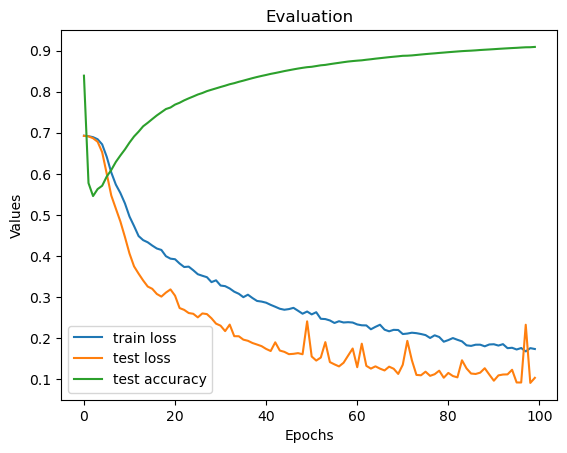

In [14]:
plt.plot([i for i in range(epochs)], train_loss_arr, label='train loss')
plt.plot([i for i in range(epochs)], test_loss_arr, label='test loss')
plt.plot([i for i in range(epochs)], test_acc_arr, label='test accuracy')
plt.title('Evaluation')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend();

# Transfer Learning

### I'm going to be using the ResNet50 pretrained model from PyTorch.

In [15]:
weights = torchvision.models.ResNet50_Weights.DEFAULT 
model = torchvision.models.resnet50(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

### Let's see how our model looks like.

In [16]:
torchinfo.summary(model=model, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

### As you can see, it is a huge model with over 25 parameters. 
### For our use, we will have to freeze the feature parameters and only train the classifying layer. 

In [17]:
for param in model.parameters():
    param.requires_grad = False

In [18]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=2048, 
                    out_features=2, # same number of output units as our number of classes
                    bias=True)).to(device)

### Let's see whether the change took place correctly.

In [19]:
torchinfo.summary(model=model, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

### As we can see, only the last Sequential layer has trainable parameters. 
### Thus, the number of trainable params dropped down from over 25 million to just 4098 parameters. 
### We are going to hopefully achieve better results with this pretrained model.

In [20]:
# Setup loss function and optimizer
model = model 
lf = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

epochs = 100
acc_fn = Accuracy(task='binary').to(device)
train_loss_arr = []
test_loss_arr = []
test_acc_arr = []

for epoch in range(epochs):
    train_loss = 0
    
    for batch, (X,y) in enumerate(train_dataloader_custom):
            
        X = X.to(device)
        y = y.to(device)
        model.train()
        
        # Forward
        y_pred = model(X)
        
        # Calculate loss
        loss = lf(y_pred, y)
        train_loss += loss
        
        # Zero grad
        optimizer.zero_grad()
        
        # Loss backward
        loss.backward()
        
        # Optimizer step
        optimizer.step()
    
    train_loss/=len(train_dataloader_custom)
    train_loss_arr.append(train_loss.cpu().detach().numpy())
    
    test_loss, test_acc= 0, 0
    model.eval() 
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_dataloader_custom):
            
            X = X.to(device)
            y = y.to(device)
            
            # Forward
            test_pred = model(X)
            
            # Calculate loss 
            test_loss += lf(test_pred, y)
            
            # Calculate accuracy 
            acc_fn.update(test_pred.argmax(dim=1).to(device), y.argmax(dim=1).to(device))
            test_acc += acc_fn.compute()
            
        test_loss /= len(test_dataloader_custom)
        test_loss_arr.append(test_loss.cpu().detach().numpy())
        test_acc /= len(test_dataloader_custom)
        test_acc_arr.append(test_acc.cpu().detach().numpy())
        
    print(f"\nEpoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc*100:.2f}%\n")


Epoch: 0 | Train loss: 0.63298 | Test loss: 0.55205, Test acc: 96.53%


Epoch: 1 | Train loss: 0.53748 | Test loss: 0.46326, Test acc: 96.52%


Epoch: 2 | Train loss: 0.47066 | Test loss: 0.39417, Test acc: 96.75%


Epoch: 3 | Train loss: 0.42240 | Test loss: 0.34397, Test acc: 96.88%


Epoch: 4 | Train loss: 0.38696 | Test loss: 0.30962, Test acc: 97.00%


Epoch: 5 | Train loss: 0.35753 | Test loss: 0.28327, Test acc: 97.09%


Epoch: 6 | Train loss: 0.33490 | Test loss: 0.25099, Test acc: 97.15%


Epoch: 7 | Train loss: 0.31502 | Test loss: 0.23436, Test acc: 97.21%


Epoch: 8 | Train loss: 0.30105 | Test loss: 0.22160, Test acc: 97.28%


Epoch: 9 | Train loss: 0.28647 | Test loss: 0.21162, Test acc: 97.35%


Epoch: 10 | Train loss: 0.27340 | Test loss: 0.20257, Test acc: 97.41%


Epoch: 11 | Train loss: 0.26695 | Test loss: 0.19512, Test acc: 97.45%


Epoch: 12 | Train loss: 0.25291 | Test loss: 0.17972, Test acc: 97.49%


Epoch: 13 | Train loss: 0.24614 | Test loss: 0.17683, Test a

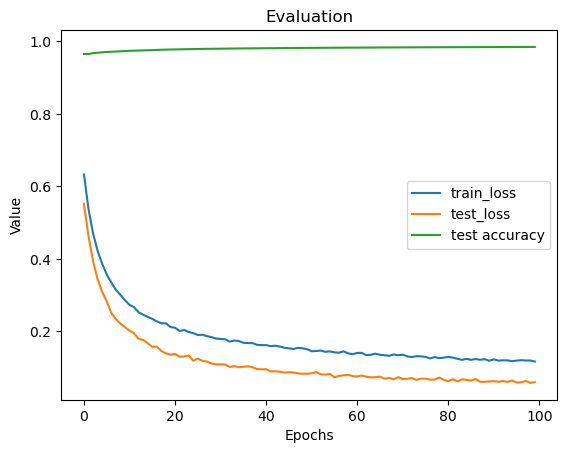

In [21]:
plt.plot([i for i in range(epochs)], train_loss_arr, label='train_loss')
plt.plot([i for i in range(epochs)], test_loss_arr, label='test_loss')
plt.plot([i for i in range(epochs)], test_acc_arr, label='test accuracy')
plt.title('Evaluation')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend();

### We can see the power of transfer learning from this!
### Albeit the simple CNN model performed fairly well, this was just a simple dataset.
### As the problem gets more complicated, never forget the power of transfer learning!